# Identify Artist from paintings
- Team: Bambu Paul, Creta Florin, Borodi Cristian, Mos Daniele

## Introduction

Computer analysis of visual art, especially paintings, is an interesting cross-disciplinary research domain.
With the spread of digitalization of art paintings,  research on diverse scientific approaches on painted images has become active.
The artistic style (or artistic movement) of a painting is a rich descriptor that captures both visual and historical information about the painting. 
Correctly identifying the artistic style of a paintings is crucial for indexing large artistic databases.
Our aim is to investigate the use of deep learning to solve the problem of detecting the artistic style of a painting.

## Dataset

- Dataset link [here](https://www.kaggle.com/ikarus777/best-artworks-of-all-time)
- We are using a dataset of paintings done by about 50 artists (found on Kaggle)
- The dataset contains three files:
  - Artists.csv: dataset of information for each artist
  - Images.zip: collection of images (full size), divided in folders and sequentially numbered
  - Resized.zip: same collection but images have been resized and extracted from folder structure
- The data was scraped from artchallenge.ru during the end of February 2019.

In [28]:
from google.colab import drive
import pandas as pd
import PIL
import matplotlib.pyplot as plt
import random
import os
import numpy as np
import imageio
import cv2
from keras.preprocessing import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

In [2]:
# Mount the google drive to fetch the data 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
artists = pd.read_csv('/content/gdrive/MyDrive/Art-dataset/artists.csv')
artists.shape

(50, 8)

In [4]:
# Show artists sorted by paintings number
artists = artists.sort_values(by=['paintings'], ascending=False)
artists_top = artists[['name', 'paintings']]
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
artists_top.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,name,paintings,class_weight
8,Vincent van Gogh,877,0.192611
30,Edgar Degas,702,0.240627
13,Pablo Picasso,439,0.384784
15,Pierre-Auguste Renoir,336,0.502738
19,Albrecht Dürer,328,0.515000
46,Paul Gauguin,311,0.543151
16,Francisco Goya,291,0.580481
31,Rembrandt,262,0.644733
20,Alfred Sisley,259,0.652201
32,Titian,255,0.662431


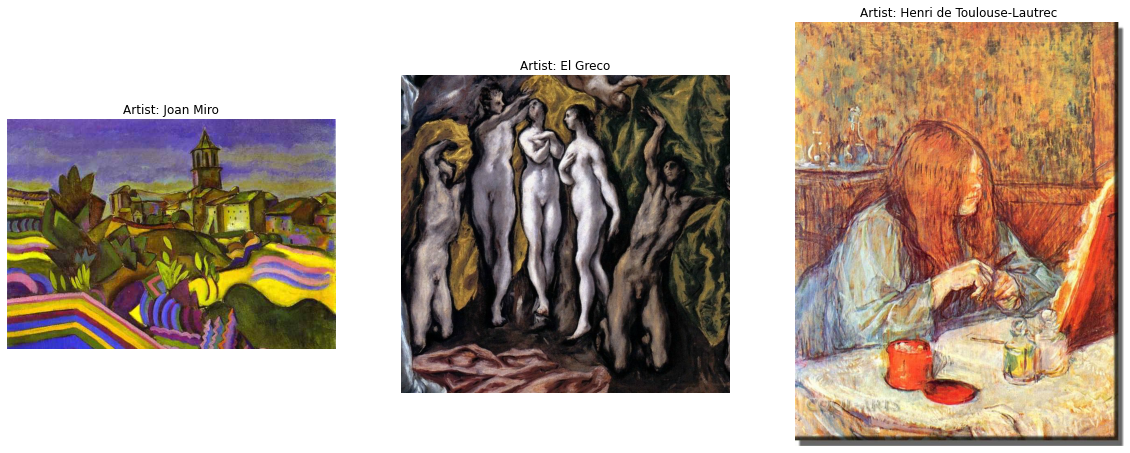

In [5]:
# See how paintings look like
fig, axes = plt.subplots(1, 3, figsize=(20,10))
images_dir = '/content/gdrive/MyDrive/Art-dataset/images/images'
artists_top_name = artists_top['name'].str.replace(' ', '_').values

for i in range(3):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

### Represent the data as a tf dataset
- adding data augmentation

In [6]:
batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = artists_top.shape[0]

In [7]:
train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   shear_range=5,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

In [8]:
train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

Found 6516 images belonging to 50 classes.


In [9]:
valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

Found 1602 images belonging to 50 classes.


## Model
- using pret-trained resnet50 model

In [15]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

94781440/94765736 [==============================] - 1s 0us/step


Add extra layers to the base model

In [16]:
n_epoch = 10

In [19]:
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [22]:
# Using Adam as an optimizer
optimizer = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [23]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [24]:
class_weights = artists_top['class_weight'].to_dict()

history1 = model.fit_generator(generator=train_generator, steps_per_epoch=train_generator.n//batch_size,
                              validation_data=valid_generator, validation_steps=valid_generator.n//batch_size,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/10
407/407 [==============================] - 329s 719ms/step - loss: 5.0669 - accuracy: 0.1934 - val_loss: 4.6090 - val_accuracy: 0.0100 - lr: 1.0000e-04
Epoch 2/10
407/407 [==============================] - 231s 555ms/step - loss: 4.3873 - accuracy: 0.3549 - val_loss: 3.9087 - val_accuracy: 0.0969 - lr: 1.0000e-04
Epoch 3/10
407/407 [==============================] - 234s 561ms/step - loss: 3.9664 - accuracy: 0.4266 - val_loss: 2.9060 - val_accuracy: 0.4169 - lr: 1.0000e-04
Epoch 4/10
407/407 [==============================] - 234s 562ms/step - loss: 3.5671 - accuracy: 0.4849 - val_loss: 2.7065 - val_accuracy: 0.4425 - lr: 1.0000e-04
Epoch 5/10
407/407 [==============================] - 233s 559ms/step - loss: 3.3020 - accuracy: 0.5023 - val_loss: 2.5470 - val_accuracy: 0.4650 - lr: 1.0000e-04
Epoch 6/10
407/407 [==============================] - 271s 653ms/step - loss: 2.9808 - accuracy: 0.5378 - val_loss: 2.6472 - val_accuracy: 0.4425 - lr: 1.0000e-04
Epoch 7/10
407/407 [==

## Testing on paintings

Predicted artist = Vincent van Gogh
Prediction probability = 75.20598769187927 %


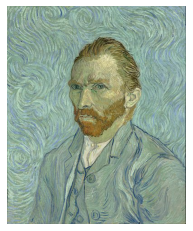

In [40]:
test_image_url = 'https://i1.wp.com/tiqets-cdn.s3.eu-west-1.amazonaws.com/wordpress/blog/wp-content/uploads/2021/04/07095440/395px-Vincent_van_Gogh_-_Self-Portrait_-_Google_Art_Project.jpg?resize=395%2C480&ssl=1'

labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())

web_image = imageio.imread(test_image_url)
web_image = cv2.resize(web_image, dsize=train_input_shape[0:2], )
web_image = image.img_to_array(web_image)
web_image /= 255.
web_image = np.expand_dims(web_image, axis=0)


prediction = model.predict(web_image)
prediction_probability = np.amax(prediction)
prediction_idx = np.argmax(prediction)

print("Predicted artist =", labels[prediction_idx].replace('_', ' '))
print("Prediction probability =", prediction_probability*100, "%")

plt.imshow(imageio.imread(test_image_url))
plt.axis('off')
plt.show()